# Now that you’ve found the answers to the questions above, design your own question. It should be sufficiently difficult, and you should be creative! You should start with a question, and then propose a predicted answer or hypothesis before writing a Spark job to answer it. Some ideas:
- Visualization of related features. Your visualization should help tell a story.
- Clustering related users, comments, or subreddits
- Summary statistics: finding mins, maxes, standard deviations, or even correlations between variables to tell us something about a subreddit or multiple subreddits. For example, perhaps users that visit /r/technology also frequently visit /r/android.
- Friend graph: can you link together ‘related’ users based on some shared interest? Maybe several users visit the same collection of subreddits. The PageRank algorithm could come in handy here.

# Clustering related comments

In [3]:
# Reading data from hdfs cluster on orion11
df = spark.read.json('hdfs://orion11:23001/RC_2005-12.bz2')
df.cache()

DataFrame[author: string, author_flair_css_class: string, author_flair_text: string, body: string, controversiality: bigint, created_utc: bigint, distinguished: string, edited: boolean, gilded: bigint, id: string, link_id: string, parent_id: string, retrieved_on: bigint, score: bigint, stickied: boolean, subreddit: string, subreddit_id: string, ups: bigint]

In [4]:
# Get schema
df.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- edited: boolean (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- retrieved_on: long (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- ups: long (nullable = true)



In [5]:
df.createOrReplaceTempView("df_view")

In [6]:
# Get top 5 subreddit
top_five_subreddit = spark.sql("SELECT subreddit FROM (SELECT subreddit, COUNT(*) AS ct FROM df_view GROUP BY subreddit) AS t ORDER BY ct DESC LIMIT 5")

top_five_subreddit.show()

+----------+
| subreddit|
+----------+
|reddit.com|
+----------+



In [7]:
# Check if our data contains deleted reddit comments
deleted_reddit_comments = spark.sql("SELECT COUNT(*) FROM df_view WHERE body LIKE '%deleted%'")
deleted_reddit_comments.show()

+--------+
|count(1)|
+--------+
|     108|
+--------+



In [8]:
reddit_comments = spark.sql("SELECT body AS comments FROM df_view WHERE body NOT LIKE '%deleted%'")
reddit_comments_df = reddit_comments.toDF("comments").toPandas()

reddit_comments_df.head()

,comments
0,A look at Vietnam and Mexico exposes the myth ...
1,"The site states ""What can I use it for? Meetin..."
2,Jython related topics by Frank Wierzbicki
3,Saft is by far the best extension you could ta...
4,How to take panoramic shots simply


In [33]:
reddit_comments_list = reddit_comments_df["comments"].values.tolist()

print(reddit_comments_list[0:5])

['A look at Vietnam and Mexico exposes the myth of market liberalisation.', 'The site states "What can I use it for? Meeting notes, Reports, technical specs Sign-up sheets, proposals and much more...", just like any other new breeed of sites that want us to store everything we have on the web. And they even guarantee multiple levels of security and encryption etc. But what prevents these web site operators fom accessing and/or stealing Meeting notes, Reports, technical specs Sign-up sheets, proposals and much more, for competitive or personal gains...? I am pretty sure that most of them are honest, but what\'s there to prevent me from setting up a good useful site and stealing all your data? Call me paranoid - I am.', 'Jython related topics by Frank Wierzbicki', 'Saft is by far the best extension you could tak onto your Safari', 'How to take panoramic shots simply']


In [34]:
# Source: https://towardsdatascience.com/aggregation-of-reddit-comments-using-a-scikit-learn-k-means-clustering-algorithm-b6fa6d451e19
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Add max features
tf_idf_vectorizer = TfidfVectorizer(max_features = 20000)
# Create vectors for each words
tf_idf = tf_idf_vectorizer.fit_transform(reddit_comments_list)
# Convert to array
tf_idf_array = tf_idf.toarray()
pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizer.get_feature_names_out()).head()

,00,000,000051,001,008,014017737x,02,02_24,04,06,...,yourself,youself,youth,youths,yp,yukk,zdnet,zealots,zillion,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
from sklearn.cluster import KMeans

modelkmeans = KMeans(n_clusters=60, init='k-means++', n_init=100)
modelkmeans.fit(tf_idf)

KMeans(n_clusters=60)
cluster_assignment = modelkmeans.labels_
clustered_sentences = [[] for i in range(60)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(reddit_comments_list[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  1
['Victor Davis Hanson does an interesting job chewing out modern day academia for losing its edge on free (ie the classical definition of liberal) thinking. Luckily, many computer science departments are immune from this type of thing.', 'Actually only about 20% of the functionality had to do with e-commerce.  Most of the work consisted of creating a good web-based site builder, and that was reasonably interesting.', 'Interesting site. Its sort of the Wikipedia of factoids', 'A pinch of addiction, two tbsp of distraction....delicious!']

Cluster  2
['You can rank the comments and demote the moronicism.', 'As Aaronsw points out, there\'s a big difference between Reddit comments and Slashdot comments.  Reddit comments are ranked. Which means not only that the lame stuff gets pushed to the bottom where you can ignore it, but that, because the order can change, users won\'t be tempted into the kind of it-is-so, it-is-not, it-is-so kind of interchange that makes Slashdot comments

So, the result above are the result of the model which clustering similar comments. Perfect example can be seen on cluster 4 where \[removed\] are grouped together in one cluster

In [39]:
# Now, to check the optimum number of cluster 

sum_of_squared_dist = []
K = range(1, 100)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(tf_idf)
    sum_of_squared_dist.append(km.inertia_)

/home/rgtjakrakartadinata/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


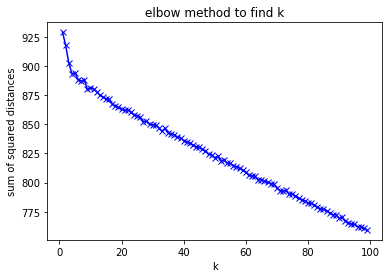

In [40]:
import matplotlib.pyplot as plt

plt.plot(K, sum_of_squared_dist, 'bx-')
plt.xlabel('k')
plt.ylabel('sum of squared distances')
plt.title('elbow method to find k')
plt.show()

Does not seems to have the elbow for this model. :')

In [1]:
sc = spark._jsc.sc() 
n_workers =  len([executor.host() for executor in sc.statusTracker().getExecutorInfos() ]) -1

print(n_workers)

10
